In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
def plot_res(img, img_eq, name1, name2):

    # plotting for orignal image        
    hist, bins = np.histogram(img.ravel(), 256)
    pdf = hist / np.prod(img.shape)
    plt.figure(figsize=(12,10))
    plt.subplot(2, 2, 1)
    plt.plot(pdf, color='r')
    plt.title(name1)
    plt.xlim([0, 256])
    plt.ylim([0, pdf.max()+0.005])
    plt.subplot(2, 2, 2)
    plt.imshow(img, cmap="gray")
    
    # plotting for equalizated image
    hist2, bin2 = np.histogram(img_eq, 256)
    pdf2 = hist2 / np.prod(img.shape)
    plt.subplot(2, 2, 3)
    plt.plot(pdf2, color='r')
    plt.title(name2)
    plt.xlim([0, 256])
    plt.ylim([0, pdf2.max()+0.005])    
    plt.subplot(2, 2, 4)   
    plt.imshow(img_eq, cmap="gray")

### Basic Histogram Equalization

In [3]:
def basic_eq(img):
    
    hist, bins = np.histogram(img.ravel(), 256, [0, 256])
    pdf = hist / np.prod(img.shape)
    cdf = hist.cumsum()
    
    # get the new cdf
    cdf = cdf *(cdf[-1] - cdf[0]) + cdf[0]

    # get new img 
    img_shape = img.shape
    img_eq = np.zeros((img_shape), dtype=np.uint8)
    img_eq = cdf[img]

    return img_eq

In [4]:
img1 = cv2.imread('couple.jpg', 0)

In [5]:
img2 = cv2.imread('a.jpg', 0)

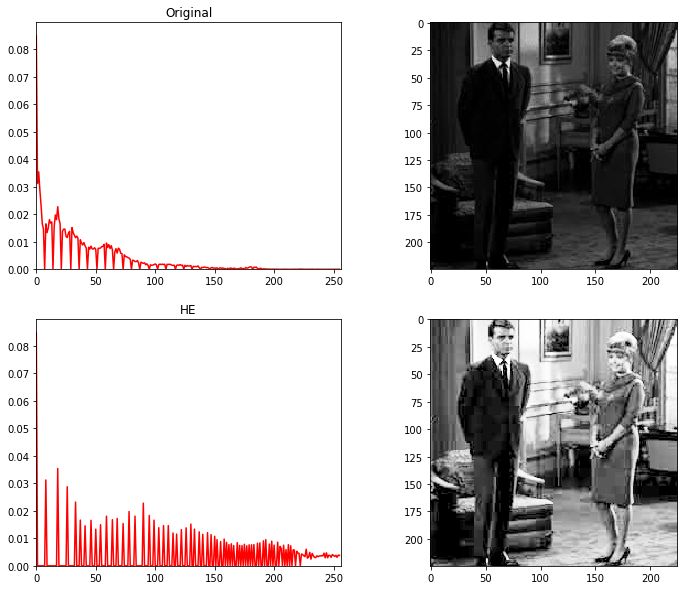

In [6]:
img1_eq = basic_eq(img1)
plot_res(img1, img1_eq, "Original", "HE")

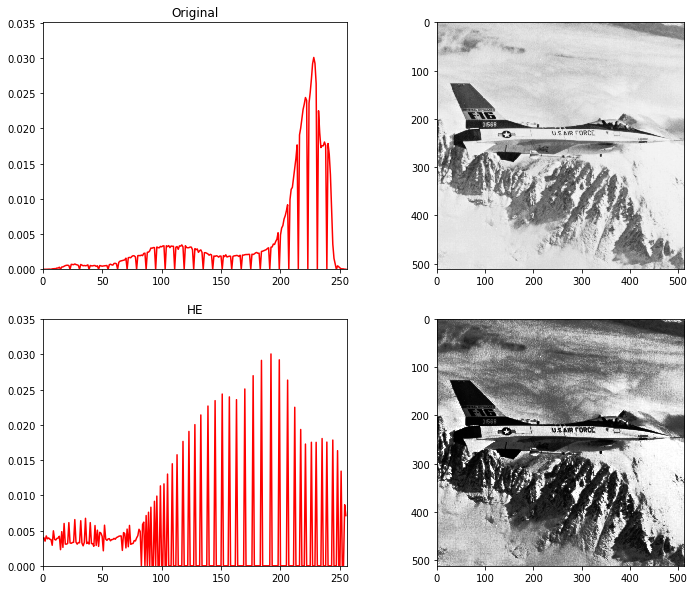

In [7]:
img2_eq = basic_eq(img2)
plot_res(img2, img2_eq, "Original", "HE")

### Basic Histogram Equalization 的缺点

+ 在低灰度值范围内密度很大（img1）的图片中，亮度会有过度的变化，使得原来很暗的图像变得异常亮，这样很不自然。
+ 在高灰度值范围内密度很大（img2）的图片中，可以看到在均衡之后，我们会在云周围看到完全不同的视觉识别。也可以观察到飞机上的字母和标志周围的对比度降低了。

直方图均衡的这种限制背后的更根本原因是，直方图均衡不考虑图像的平均亮度。
> More fundamental reason behind the such limi- tations of the histogram equalzat,ion is that the his- toram equalzation does not take the mean brightness of an image into account.

### Bi-Histogram Equalization(BHE)

用 $X_{m}$ 表示图像 X 的平均值，并假设 $X_{m} ∈\left \{ X_{0}, X_{1}, ..., X_{L-1} \right \}$ ，基于均值可以将图像分为两部分 $X_{L}$ 和 $X_{U}$，整个可以表示成：$$X = X_{L}\cup X_{U}$$

然后根据分离的两个子图片，分别求转换方程（cdf），然后合并 cdf，最后对整个图片进行均衡化。

In [8]:
def bi_eq(img):
    
    hist, bins = np.histogram(img.ravel(), 256, [0, 256])
    pdf = hist / np.prod(img.shape)
    cdf = hist.cumsum()

    
    # image mean
    img_mean = np.mean(img)
    
    # getting two subimages
    img_l = np.zeros((img.shape))
    img_u = np.zeros((img.shape))
    
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if img[i][j] <= img_mean:
                img_l[i][j] = img[i][j]
            else:
                img_u[i][j] = img[i][j]
                
    # cdf of low subimage
    hist_l, bins_l = np.histogram(img_l, 256, [0, 256])
    cdf_l = hist_l.cumsum()

    # transform func of low
    cdf_l = cdf_l *(img_mean - img.min()) + img.min()          
    
    
    # cdf of upper subimage
    hist_u, bins_u = np.histogram(img_u, 256, [0, 256])
    cdf_u = hist_u.cumsum()

    # transform func of upper
    cdf_u = cdf_u *(img.max() - (int(img_mean) + 1)) + (int(img_mean) + 1)
    
    cdf_new = cdf_l + cdf_u
    new_img = cdf_new[img.ravel()]
    img_eq = np.reshape(new_img, img.shape)
    
    return img_eq

### Compare HE with BHE

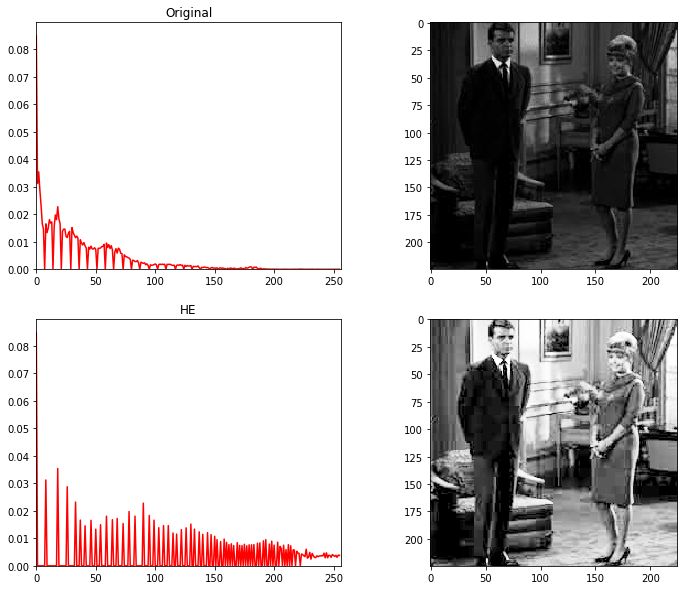

In [9]:
img1_eq = basic_eq(img1)
plot_res(img1, img1_eq, "Original", "HE")

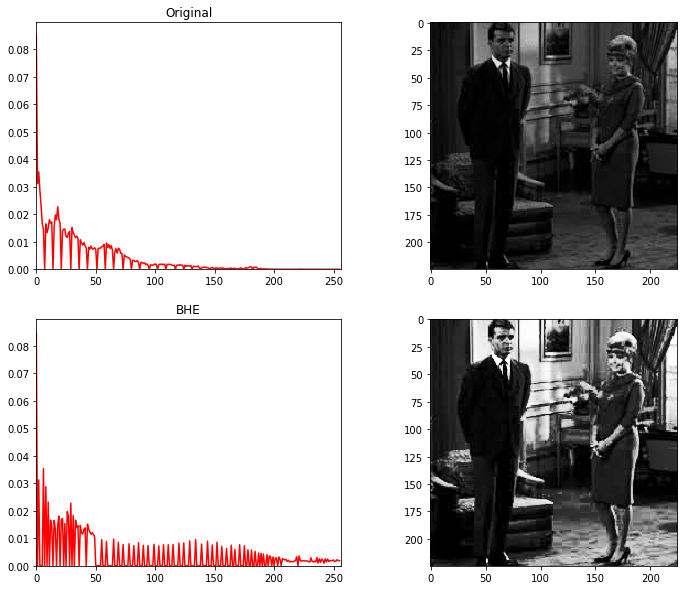

In [10]:
img1_bieq = bi_eq(img1)
plot_res(img1, img1_bieq, "Original", "BHE")

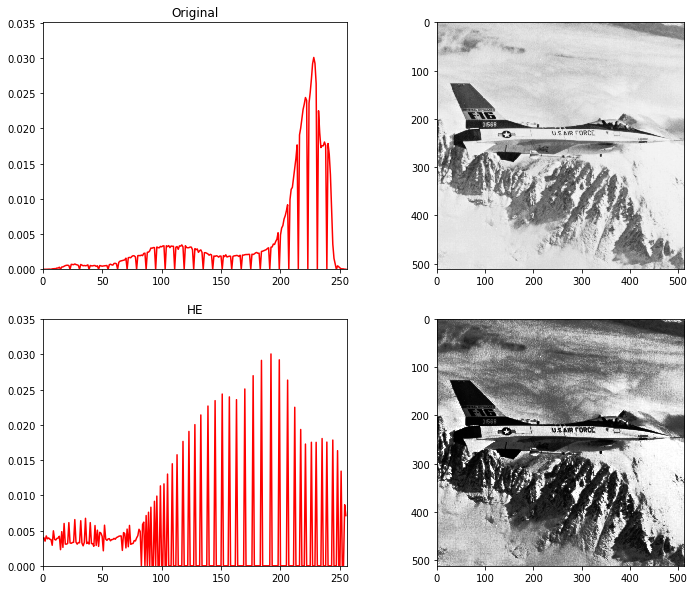

In [11]:
img2_eq = basic_eq(img2)
plot_res(img2, img2_eq, "Original", "HE")

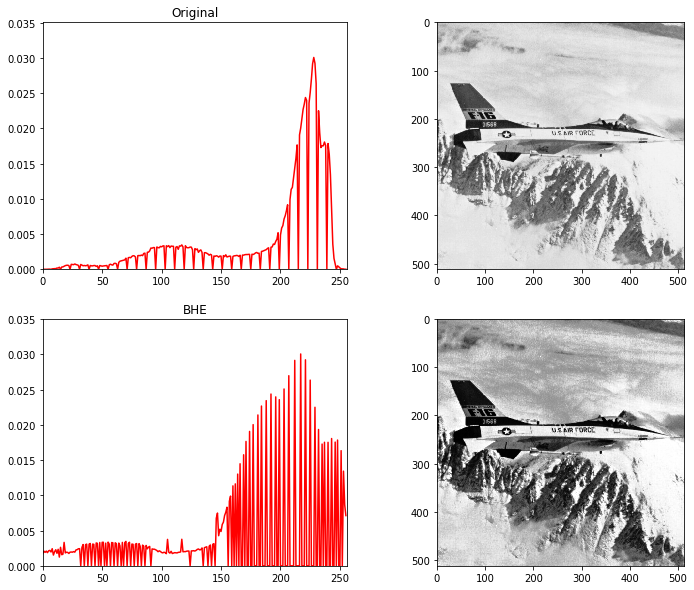

In [12]:
img2_bieq = bi_eq(img2)
plot_res(img2, img2_bieq, "Original", "BHE")

### Clipped Histogram Equalization

在一般的直方图均衡化的过程中，不仅提高了对比度，连带着图片里的噪音也被提高了，这会对一些图像分析造成困扰。Clipped Histogram Equalization 的提出就是为了解决这个问题的，该方法会一边限制噪音，一边提高对比度。CHE 的方法如下图所示：

![CHE Method](che.jpg)

预先指定一个上限，CHE 将超出上限的直方图的一部分重新分配到整个动态范围内。

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [32]:
def clipped_eq(img, limit):

    hist, bins = np.histogram(img.ravel(), 256, [0, 256])
    #pdf = hist / np.prod(img.shape)
    #cdf = hist.cumsum()
    
    new_hist = np.zeros((256))

    for i in range(0, 256):
        new_hist[i] = np.clip(hist[i], 0, limit)
        
    new_cdf = new_hist.cumsum()
    new_cdf = new_cdf * 255
    img_eq = new_cdf[img]
    
    return img_eq

### Compare HE with CHE

In [33]:
img1 = cv2.imread('./img1/(24).jpg', 0)

In [34]:
img2 = cv2.imread('football.jpg', 0)

In [35]:
def plot_hist(img):
    
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    plt.plot(hist, color='r')

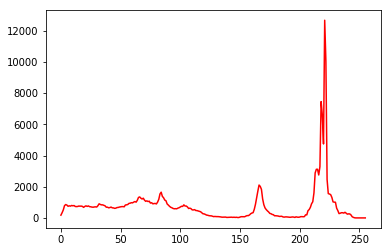

In [36]:
plot_hist(img1)

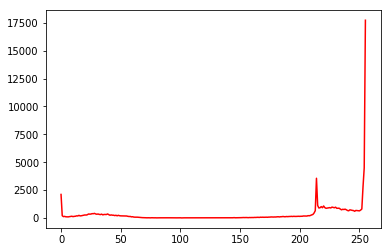

In [37]:
plot_hist(img2)

In [52]:
img1_eq = basic_eq(img1)
img1_ceq = clipped_eq(img1, 500)

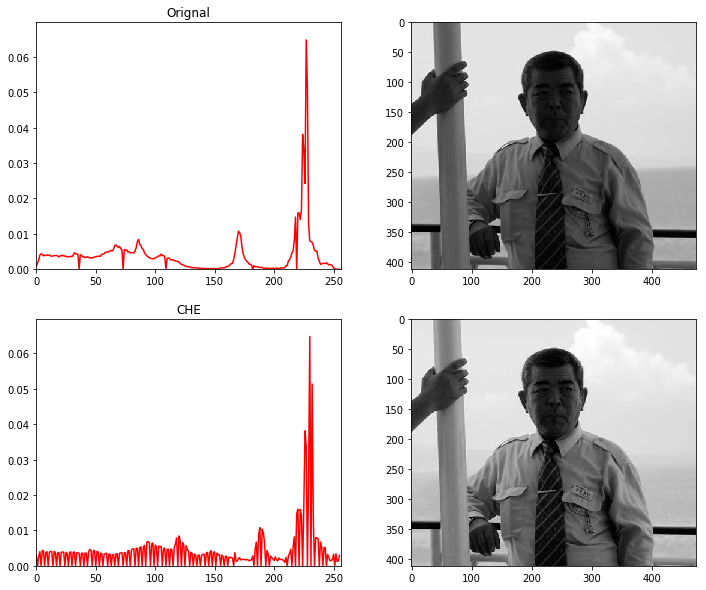

In [54]:
plot_res(img1, img1_ceq, "Orignal", "CHE")

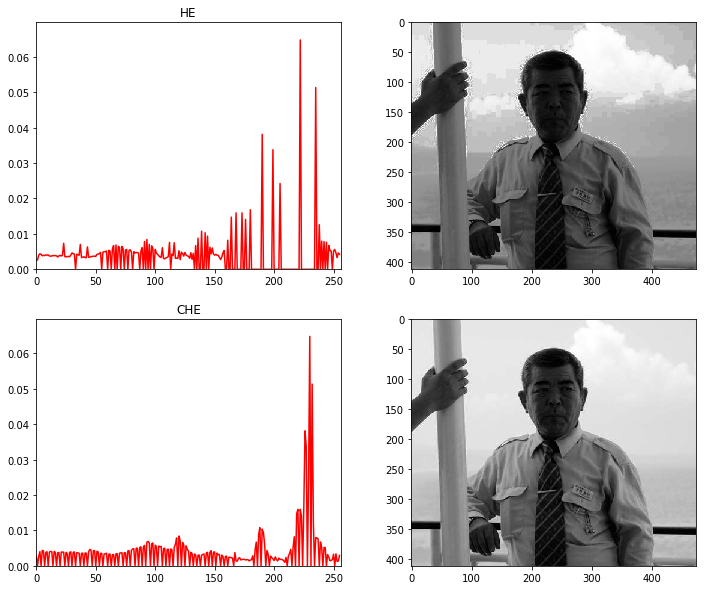

In [55]:
plot_res(img1_eq, img1_ceq, "HE", "CHE")

In [70]:
img2_eq = basic_eq(img2)
img2_ceq = clipped_eq(img2, 2000)

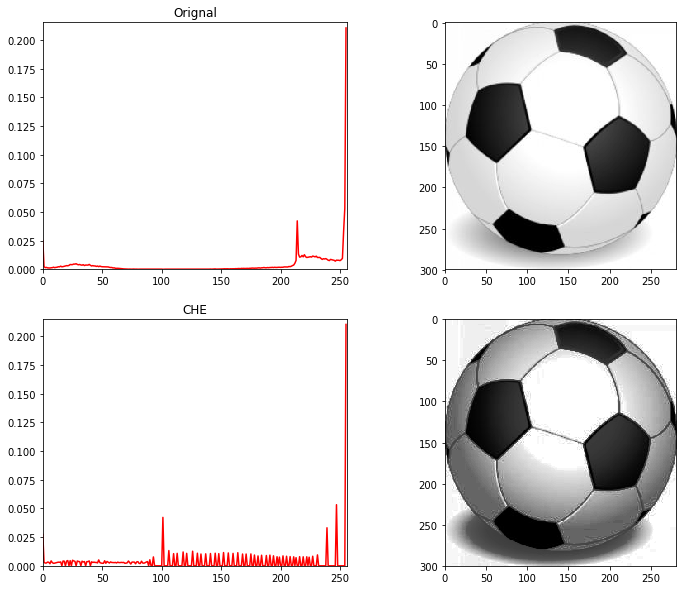

In [71]:
plot_res(img2, img2_ceq, "Orignal", "CHE")

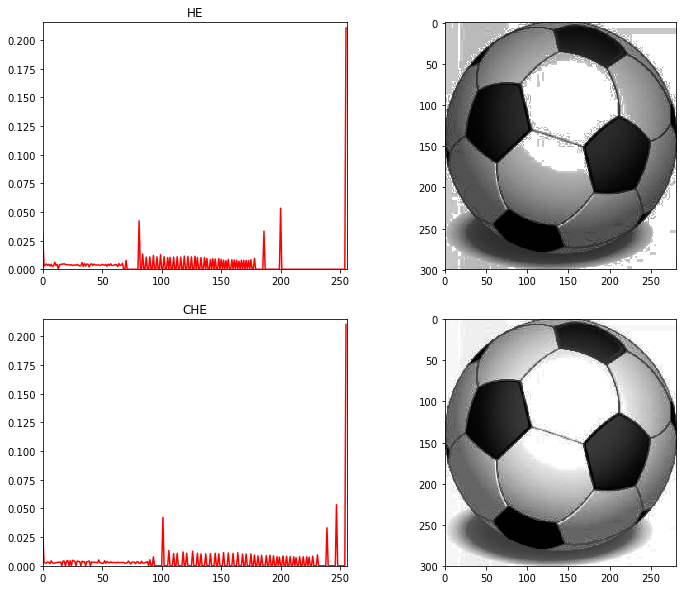

In [72]:
plot_res(img2_eq, img2_ceq, "HE", "CHE")

### CHE 的缺点

CHE 的缺点很容易发现，就想本节刚开始做的那样先要 plot 图像的直方图，然后根据直方图的结果手动设置限制的高度范围。同时截取高度再重新分配的操作增加了复杂度。因此，后面提出的 
BHEPL 方法会改进这些缺点。

### Bi-Histogram Equalization with a Plateau Limit(BHEPL)

该方法就是在 BHE 的方法中加入了高原限制（上限） $T_{L}$ 和 $T_{U}$:

![](TL.jpg)

![](TU.jpg)

实际上，$T_{L}$ 是 $h_{L}$ 的平均值， $T_{U}$ 是 $h_{U}$ 的平均值。

下面为了控制增强率，$h_{L}$ 和 $h_{U}$ 会按照下面的公式进行裁剪：

![](hcl.jpg)

![](hul.jpg)

